# Plot the FCA result (30 miles threshold/exclude London)

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

In [6]:
conda install --channel conda-forge cartopy

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/envs/sds2020

  added / updated specs:
    - cartopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.8  |       ha878542_0         139 KB  conda-forge
    cartopy-0.17.0             |py37h17ca249_1015         1.8 MB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_1         145 KB  conda-forge
    openssl-1.1.1k             |       h7f98852_0         2.1 MB  conda-forge
    owslib-0.25.0              |     pyhd8ed

# Read data for plotting (generated in fca_access_result.ipynb)

In [43]:
#MSOA_fca = pd.read_csv('fca_result_before_norm_exclude_London.csv', low_memory=False)
MSOA_fca = gpd.read_file('fca_result_before_norm_exclude_London.gpkg')
MSOA_fca = MSOA_fca.to_crs('epsg:27700')
MSOA_fca.shape

(5806, 25)

In [44]:
MSOA_fca.describe()

pop0_17     pop18over     2sfca_10     2sfca_15     2sfca_20  \
count  5806.000000   5806.000000  5806.000000  5806.000000  5806.000000   
mean   1729.990010   6458.063038     0.000065     0.000065     0.000065   
std     592.590161   1617.815527     0.000041     0.000032     0.000029   
min     272.000000   3769.000000     0.000000     0.000000     0.000000   
25%    1321.000000   5314.250000     0.000041     0.000047     0.000051   
50%    1628.000000   6166.500000     0.000062     0.000065     0.000065   
75%    2018.000000   7233.750000     0.000085     0.000083     0.000084   
max    7354.000000  22695.000000     0.000643     0.000214     0.000157   

          2sfca_25     2sfca_30    E2sfca_10    E2sfca_15    E2sfca_20  ...  \
count  5806.000000  5806.000000  5806.000000  5806.000000  5806.000000  ...   
mean      0.000065     0.000065     0.000064     0.000064     0.000065  ...   
std       0.000027     0.000027     0.000049     0.000039     0.000034  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000052     0.000052     0.000033     0.000040     0.000044  ...   
50%       0.000066     0.000067     0.000059     0.000061     0.000064  ...   
75%       0.000082     0.000082     0.000087     0.000085     0.000083  ...   
max       0.000169     0.000168     0.000549     0.000304     0.000230  ...   

          3sfca_15     3sfca_20     3sfca_25     3sfca_30  18over1st_dose  \
count  5806.000000  5806.000000  5806.000000  5806.000000     5806.000000   
mean      0.000065     0.000065     0.000065     0.000065     5859.091113   
std       0.000041     0.000035     0.000032     0.000029     1382.062442   
min       0.000000     0.000000     0.000000     0.000000     2718.000000   
25%       0.000043     0.000047     0.000050     0.000051     4857.000000   
50%       0.000061     0.000063     0.000064     0.000065     5640.000000   
75%       0.000083     0.000082     0.000081     0.000080     6615.000000   
max       0.000569     0.000364     0.000251     0.000198    18200.000000   

       18over2nd_dose  18over_2dose_total  vaccination_percentage_1stdose  \
count     5806.000000         5806.000000                     5806.000000   
mean      5579.413365        11438.504478                        0.910011   
std       1342.392555         2711.012021                        0.077073   
min       1239.000000         5112.000000                        0.372769   
25%       4617.000000         9483.250000                        0.878451   
50%       5392.500000        11030.500000                        0.925843   
75%       6336.000000        12943.750000                        0.962662   
max      16114.000000        34314.000000                        1.000000   

       vaccination_percentage_2nddose  vaccination_percentage_total  
count                     5806.000000                   5806.000000  
mean                         0.869698                      0.890059  
std                          0.095662                      0.086103  
min                          0.096557                      0.270346  
25%                          0.830739                      0.855090  
50%                          0.889561                      0.907344  
75%                          0.932424                      0.947706  
max                          1.000000                      1.000000  

[8 rows x 23 columns]

## Map plot code

In [45]:
# function for scale bar
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

In [62]:
fca = MSOA_fca[['MSOA11CD','2sfca_10','2sfca_15','2sfca_20','2sfca_25','2sfca_30',
                     'E2sfca_10','E2sfca_15','E2sfca_20','E2sfca_25','E2sfca_30',
                     '3sfca_10','3sfca_15','3sfca_20','3sfca_25','3sfca_30',
                     'geometry']]

fca result * 100000 for map plot

In [63]:
fca['2sfca_10'] = round(fca['2sfca_10']*100000,1)
fca['2sfca_15'] = round(fca['2sfca_15']*100000,1)
fca['2sfca_20'] = round(fca['2sfca_20']*100000,1)
fca['2sfca_25'] = round(fca['2sfca_25']*100000,1)
fca['2sfca_30'] = round(fca['2sfca_30']*100000,1)
fca['E2sfca_10'] = round(fca['E2sfca_10']*100000,1)
fca['E2sfca_15'] = round(fca['E2sfca_15']*100000,1)
fca['E2sfca_20'] = round(fca['E2sfca_20']*100000,1)
fca['E2sfca_25'] = round(fca['E2sfca_25']*100000,1)
fca['E2sfca_30'] = round(fca['E2sfca_30']*100000,1)
fca['3sfca_10'] = round(fca['3sfca_10']*100000,1)
fca['3sfca_15'] = round(fca['3sfca_15']*100000,1)
fca['3sfca_20'] = round(fca['3sfca_20']*100000,1)
fca['3sfca_25'] = round(fca['3sfca_25']*100000,1)
fca['3sfca_30'] = round(fca['3sfca_30']*100000,1)
fca.describe()

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


2sfca_10     2sfca_15     2sfca_20     2sfca_25     2sfca_30  \
count  5806.000000  5806.000000  5806.000000  5806.000000  5806.000000   
mean      6.470634     6.487220     6.484464     6.486686     6.482415   
std       4.084597     3.213463     2.880420     2.732994     2.679115   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.100000     4.700000     5.100000     5.200000     5.200000   
50%       6.200000     6.500000     6.500000     6.600000     6.700000   
75%       8.475000     8.300000     8.400000     8.200000     8.200000   
max      64.300000    21.400000    15.700000    16.900000    16.800000   

         E2sfca_10    E2sfca_15    E2sfca_20    E2sfca_25    E2sfca_30  \
count  5806.000000  5806.000000  5806.000000  5806.000000  5806.000000   
mean      6.406924     6.442008     6.460041     6.469084     6.473648   
std       4.909295     3.905924     3.387866     3.086829     2.904211   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       3.300000     4.000000     4.400000     4.700000     5.000000   
50%       5.900000     6.100000     6.350000     6.500000     6.500000   
75%       8.700000     8.500000     8.300000     8.300000     8.200000   
max      54.900000    30.400000    23.000000    18.000000    14.900000   

          3sfca_10     3sfca_15     3sfca_20     3sfca_25     3sfca_30  
count  5806.000000  5806.000000  5806.000000  5806.000000  5806.000000  
mean      6.446383     6.463917     6.474406     6.480968     6.483638  
std       5.287212     4.122722     3.508827     3.152258     2.926066  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       3.500000     4.300000     4.700000     5.000000     5.100000  
50%       5.900000     6.100000     6.300000     6.400000     6.500000  
75%       8.500000     8.300000     8.200000     8.100000     8.000000  
max      74.600000    56.900000    36.400000    25.100000    19.800000

In [60]:
shape = gpd.read_file('MSOA_Boundary_with_population_base.gpkg')
shape = shape.to_crs('epsg:27700')
shape.shape

(5808, 5)

In [68]:
shape.drop(columns=['MSOA11NM','pop0_17','pop18over'], axis=1,inplace=True)

In [69]:
shape = pd.merge(left=shape, right=fca, how='left', left_on='MSOA11CD', right_on='MSOA11CD')

In [74]:
shape = shape[['MSOA11CD','2sfca_10','2sfca_15','2sfca_20','2sfca_25','2sfca_30',
                     'E2sfca_10','E2sfca_15','E2sfca_20','E2sfca_25','E2sfca_30',
                     '3sfca_10','3sfca_15','3sfca_20','3sfca_25','3sfca_30']].fillna(0)

In [78]:
m = gpd.read_file('MSOA_Boundary_with_population_base.gpkg').to_crs('epsg:27700')
m.drop(columns=['MSOA11NM','pop0_17','pop18over'], axis=1,inplace=True)
m

MSOA11CD                                           geometry
0     E02000984  POLYGON ((372121.741 414318.582, 372147.184 41...
1     E02000985  POLYGON ((372971.325 411456.076, 373104.966 41...
2     E02000986  POLYGON ((372147.184 413616.095, 372503.949 41...
3     E02000987  POLYGON ((363078.556 411480.529, 363041.920 41...
4     E02000988  POLYGON ((371044.136 412457.779, 371567.570 41...
...         ...                                                ...
5803  E02006922  MULTIPOLYGON (((601481.105 224815.326, 601485....
5804  E02006926  POLYGON ((561100.600 178929.667, 560928.979 17...
5805  E02006932  POLYGON ((335757.632 390987.474, 335739.219 39...
5806  E02006933  POLYGON ((335096.788 389638.891, 334715.024 38...
5807  E02006934  POLYGON ((334805.261 391362.101, 334590.333 39...

[5808 rows x 2 columns]

In [79]:
fca = pd.merge(left=m, right=shape, how='left', left_on='MSOA11CD', right_on='MSOA11CD')
fca

MSOA11CD                                           geometry  2sfca_10  \
0     E02000984  POLYGON ((372121.741 414318.582, 372147.184 41...       5.8   
1     E02000985  POLYGON ((372971.325 411456.076, 373104.966 41...       5.3   
2     E02000986  POLYGON ((372147.184 413616.095, 372503.949 41...       4.7   
3     E02000987  POLYGON ((363078.556 411480.529, 363041.920 41...       5.1   
4     E02000988  POLYGON ((371044.136 412457.779, 371567.570 41...       4.8   
...         ...                                                ...       ...   
5803  E02006922  MULTIPOLYGON (((601481.105 224815.326, 601485....      11.0   
5804  E02006926  POLYGON ((561100.600 178929.667, 560928.979 17...      12.9   
5805  E02006932  POLYGON ((335757.632 390987.474, 335739.219 39...       9.0   
5806  E02006933  POLYGON ((335096.788 389638.891, 334715.024 38...       8.8   
5807  E02006934  POLYGON ((334805.261 391362.101, 334590.333 39...       8.7   

      2sfca_15  2sfca_20  2sfca_25  2sfca_30  E2sfca_10  E2sfca_15  E2sfca_20  \
0          5.3       7.4       7.4       7.0        4.4        5.2        5.6   
1          5.6       7.0       7.5       6.7        4.9        5.3        5.5   
2          7.7       8.1       7.7       7.1        5.3        5.4        5.8   
3          3.2       5.0       6.9       7.2        3.5        4.0        4.0   
4          8.1       8.3       7.8       7.2        6.3        6.0        6.2   
...        ...       ...       ...       ...        ...        ...        ...   
5803       9.0      12.1      10.5      10.5       13.2       12.7       12.1   
5804      11.5       8.1       8.3      11.4        7.3       10.3       10.4   
5805       6.7       6.8       5.7       5.3       12.0       10.1        9.1   
5806       6.1       5.9       5.6       5.2       10.2        8.9        8.2   
5807       6.5       7.3       5.6       5.3       10.8        9.4        8.6   

      E2sfca_25  E2sfca_30  3sfca_10  3sfca_15  3sfca_20  3sfca_25  3sfca_30  
0           6.0        6.3       4.9       5.2       5.4       5.4       5.4  
1           5.8        6.1       5.4       5.4       5.5       5.5       5.5  
2           6.2        6.6       6.1       5.7       5.5       5.4       5.4  
3           4.2        4.6       4.3       4.5       5.2       5.3       5.1  
4           6.6        6.9       6.6       6.0       5.6       5.5       5.5  
...         ...        ...       ...       ...       ...       ...       ...  
5803       11.8       11.6      11.1      11.2      11.0      10.4       9.8  
5804        9.7        9.2       5.2      10.6      11.3       9.8       7.9  
5805        8.4        7.9      10.3       7.9       7.4       7.1       6.9  
5806        7.7        7.3       9.9       7.6       7.1       6.9       6.7  
5807        8.1        7.6      10.4       7.7       7.2       6.9       6.8  

[5808 rows x 17 columns]

In [ ]:
# Read the IMD data
imd = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/imd2019_msoa_level_data.csv')
# Read the Ethnic group data
ethnic = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/ethnic_group_2011.csv')
# read car data
car = pd.read_csv('https://raw.githubusercontent.com/LingruFeng/dissertation/main/data_raw/CARVAN_MSOAIZ_England_Scotland_Wales_Descriptions.csv')
# Merge IMD/Ethnic/Car data
fca = pd.merge(left=fca, right=imd[['MSOAC','IMD19 SCORE','MSOADECILE']], how='left', left_on='MSOA11CD', right_on='MSOAC')
fca = pd.merge(left=fca, right=ethnic, how='left', left_on='MSOA11CD', right_on='MSOA')
fca = pd.merge(left=fca, right=car, how='left', left_on='MSOA11CD', right_on='GEO_CODE')
# Drop useless columns
fca = fca.drop(['MSOAC', 'MSOA','Households_with_at_least_one_vars_or_vans','Total_households','GEO_CODE'], axis=1)

In [162]:
fca.to_file("fca_resultx100000.gpkg", driver="GPKG")

In [174]:
fca = gpd.read_file('fca_resultx100000.gpkg').to_crs('epsg:27700')

## Accessibility map plot(When the service radius is 10/15/20/25/30 miles driving distance)

In [116]:
def access_break(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    map = fca.plot(ax=ax,column=column, edgecolor='None',
              scheme="User_Defined",classification_kwds=dict(bins=[1.7,4.4,5.9,7.3,8.9,10.9]),legend=True)
    ax.axis('off')

    leg = ax.get_legend()
    leg._loc = (0.05,0.3)
    leg.set_title("Accessbility (10⁻⁵)")
    leg.get_title().set_fontsize('23')
    leg.get_texts()[0].set_fontsize('22')
    leg.get_texts()[1].set_fontsize('22')
    leg.get_texts()[2].set_fontsize('22')
    leg.get_texts()[3].set_fontsize('22')
    leg.get_texts()[4].set_fontsize('22')
    leg.get_texts()[5].set_fontsize('22')
    leg.get_texts()[6].set_fontsize('22')
    leg.get_texts()[0].set_text('[0,1.7]')
    leg.get_texts()[1].set_text('(1.7,4.4]')
    leg.get_texts()[2].set_text('(4.4,5.9]')
    leg.get_texts()[3].set_text('(5.9,7.3]')
    leg.get_texts()[4].set_text('(7.3,8.9]')
    leg.get_texts()[5].set_text('(8.9,10.9]')
    leg.get_texts()[6].set_text('(10.9,'+str(fca[column].max())+']')
    
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size=23)
    scale_bar(ax, (0.13, 0.65), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(fca[column], k=7)
    legendgram( fig,ax = ax, 
                y = fca[column], breaks = q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

### 2SFCA

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


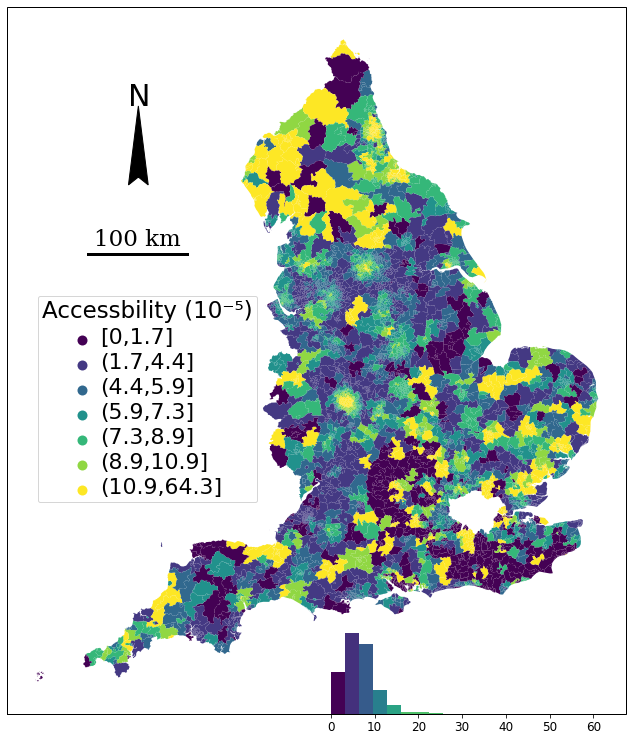

In [117]:
# 10 miles
access_break('2sfca_10')
plt.savefig('Results/2sfca_10.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


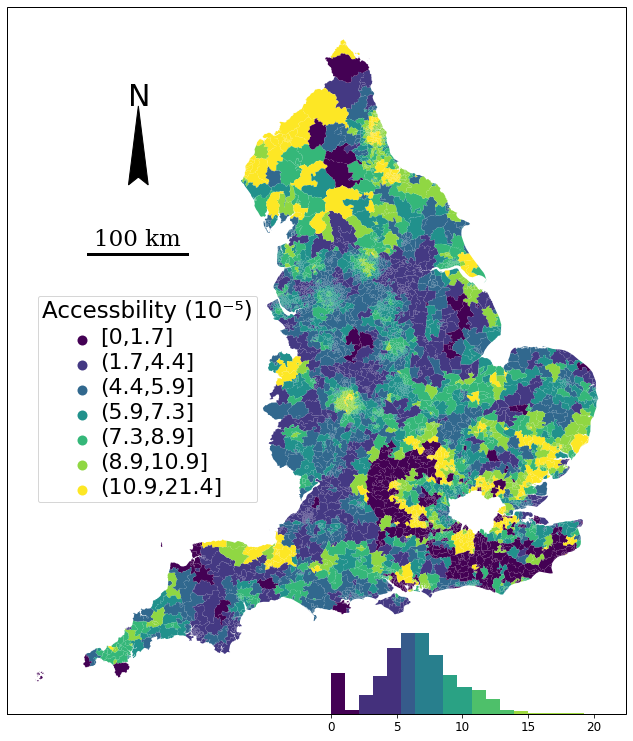

In [118]:
# 15 miles
access_break('2sfca_15')
plt.savefig('Results/2sfca_15.tif', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


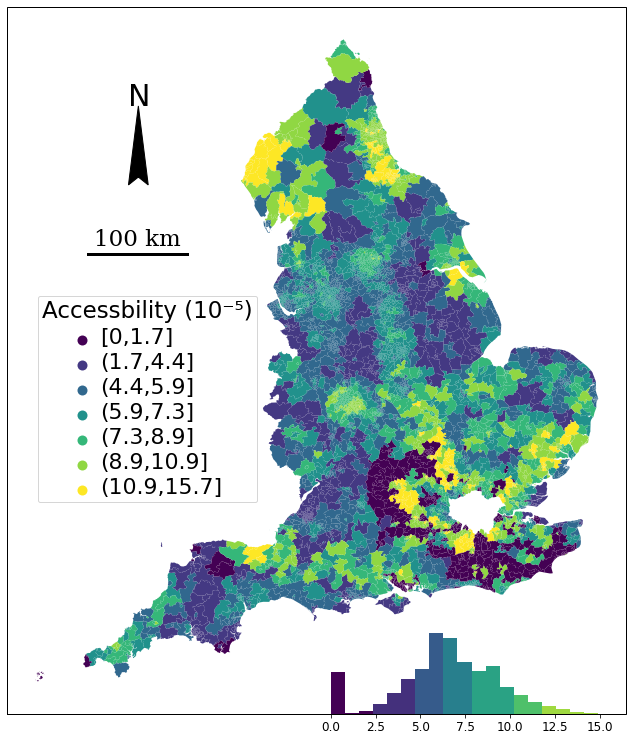

In [119]:
#20 miles
access_break('2sfca_20')
plt.savefig('Results/2sfca_20.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


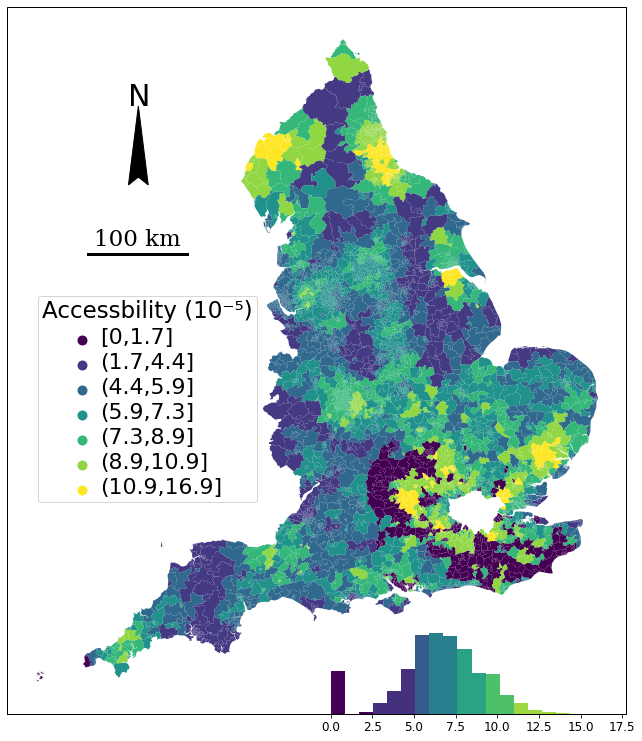

In [120]:
#25 miles
access_break('2sfca_25')
plt.savefig('Results/2sfca_25.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


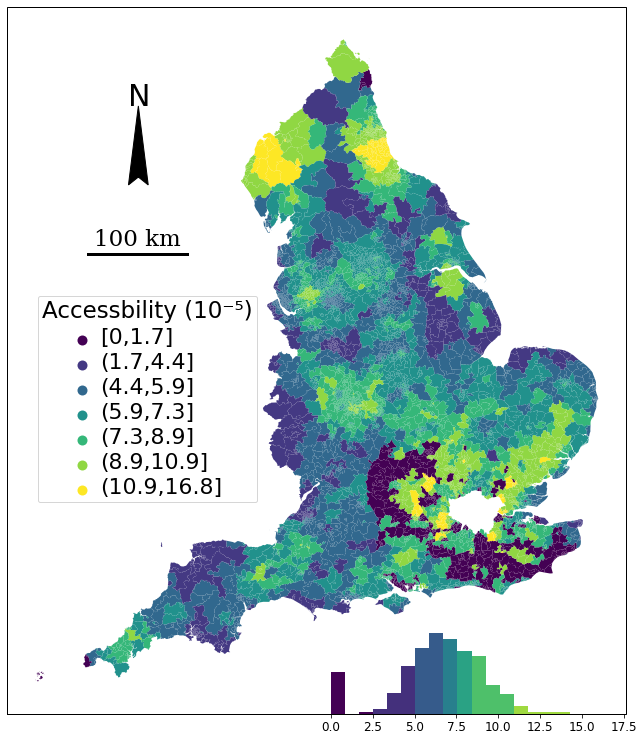

In [121]:
# 30 miles
access_break('2sfca_30')
plt.savefig('Results/2sfca_30.tiff', dpi=300,bbox_inches='tight')

### E2SFCA

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


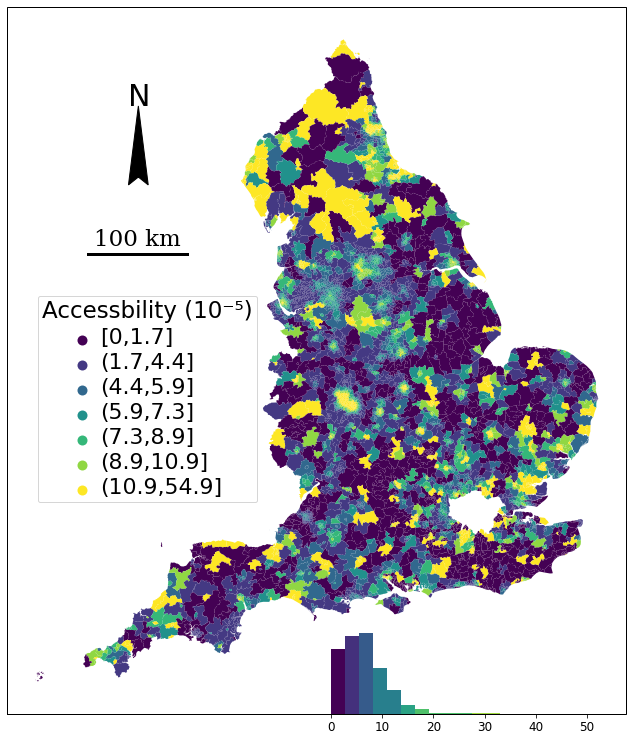

In [122]:
# 10 miles
access_break('E2sfca_10')
plt.savefig('Results/E2sfca_10.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


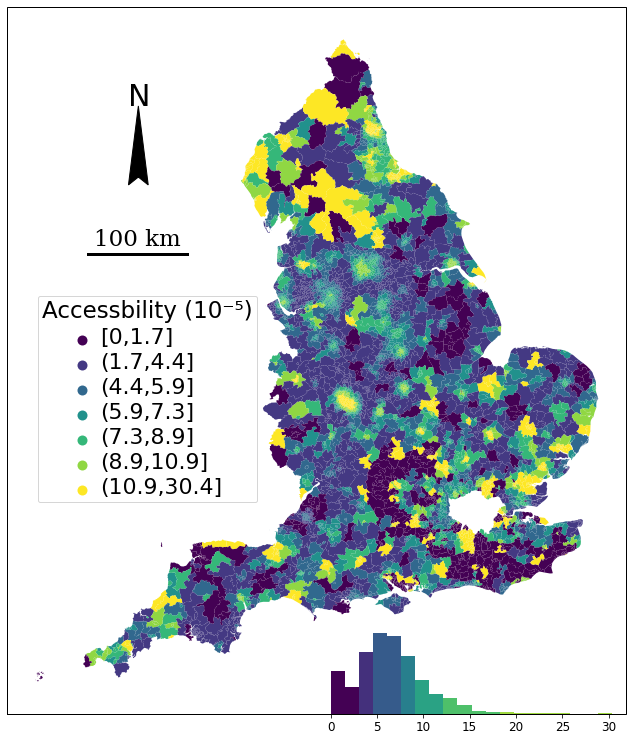

In [123]:
# 15 miles
access_break('E2sfca_15')
plt.savefig('Results/E2sfca_15.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


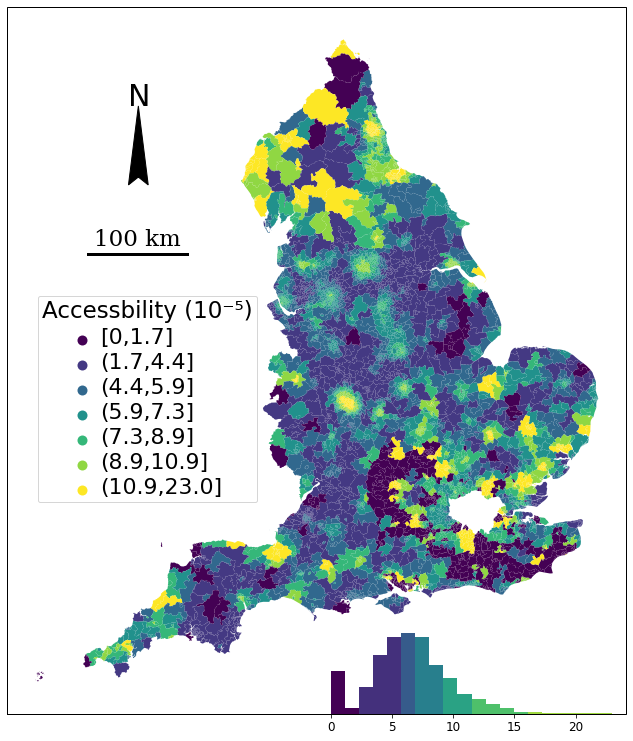

In [124]:
# 20 miles
access_break('E2sfca_20')
plt.savefig('Results/E2sfca_20.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


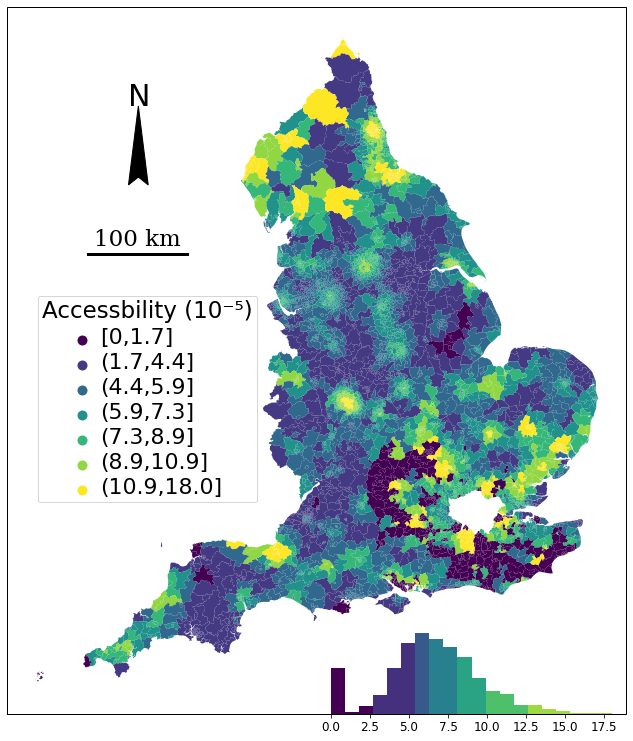

In [125]:
# 25 miles
access_break('E2sfca_25')
plt.savefig('Results/E2sfca_25.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


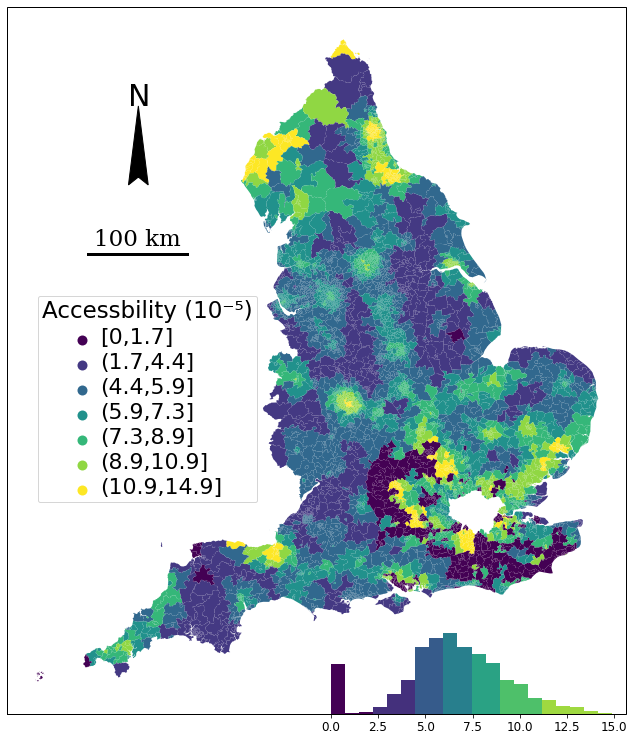

In [126]:
# 30 miles
access_break('E2sfca_30')
plt.savefig('Results/E2sfca_30.tiff', dpi=300,bbox_inches='tight')

### 3SFCA

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


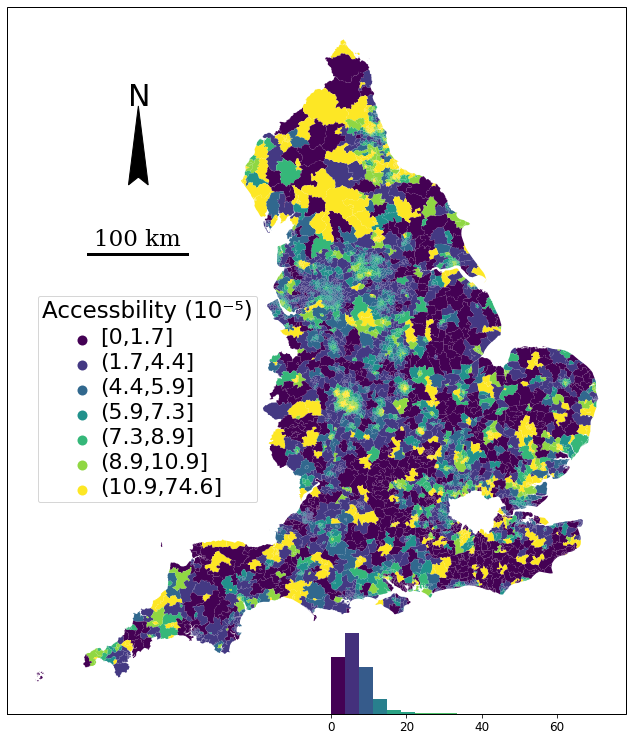

In [127]:
# 10 miles
access_break('3sfca_10')
plt.savefig('Results/3sfca_10.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


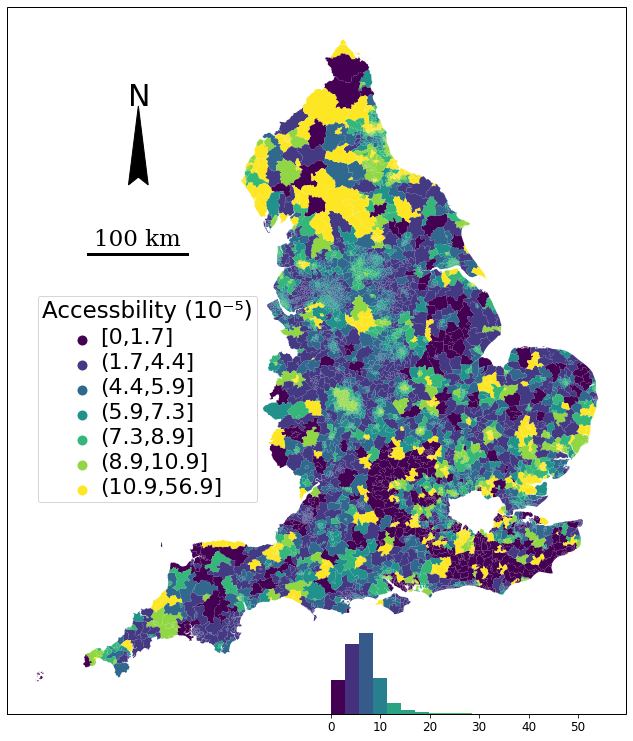

In [128]:
# 15 miles
access_break('3sfca_15')
plt.savefig('Results/3sfca_15.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


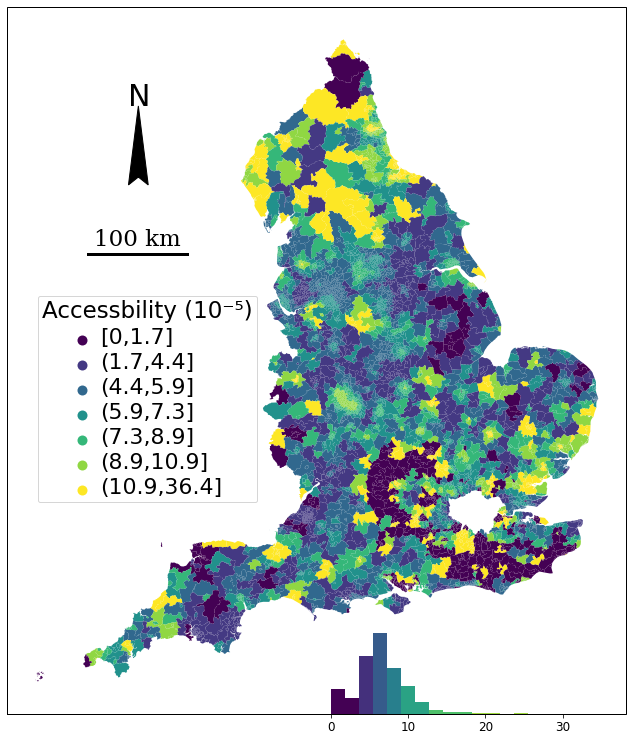

In [129]:
# 20 miles
access_break('3sfca_20')
plt.savefig('Results/3sfca_20.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


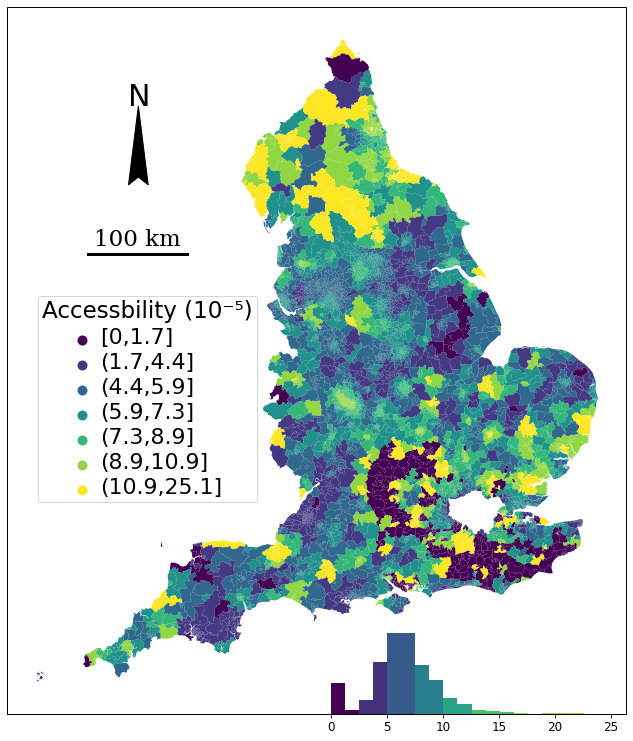

In [130]:
# 25 miles
access_break('3sfca_25')
plt.savefig('Results/3sfca_25.tiff', dpi=300,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


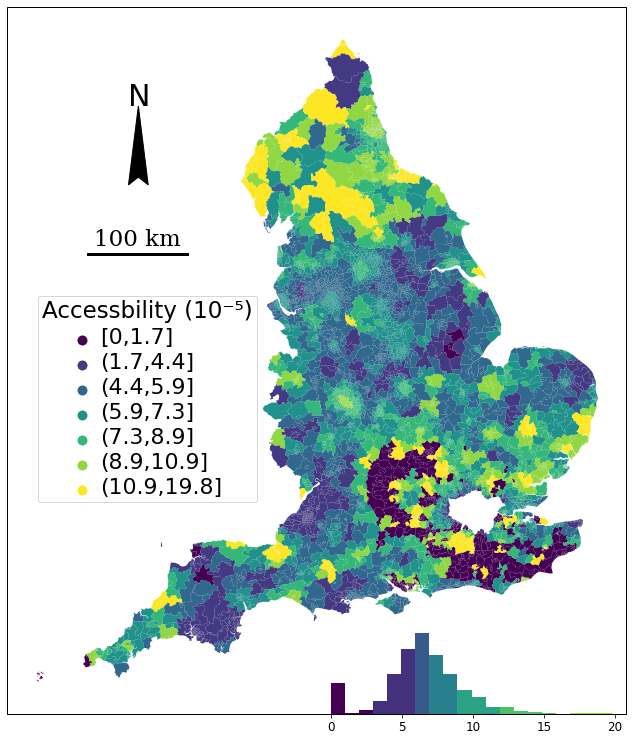

In [131]:
# 30 miles
access_break('3sfca_30')
plt.savefig('Results/3sfca_30.tiff', dpi=300,bbox_inches='tight')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA
#### 10mile

In [138]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.10056604948775796
p-value: 1.5825838691960137e-14
Spearman correlation coefficient: -0.12597160348923986
p-value: 5.6887104499830235e-22


#### 15 mile

In [135]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.08970960261985567
p-value: 7.491504097688527e-12
Spearman correlation coefficient: -0.09597173618350484
p-value: 2.3341328679198216e-13


#### 20 mile

In [136]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.10584813756926738
p-value: 6.149949422600387e-16
Spearman correlation coefficient: -0.10526248369795357
p-value: 8.887732676452063e-16


#### 25 mile

In [139]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.09879479358274385
p-value: 4.532602634564434e-14
Spearman correlation coefficient: -0.09793645257100479
p-value: 7.49744973134869e-14


#### 30 mile

In [140]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.09104675751209351
p-value: 3.641346160209059e-12
Spearman correlation coefficient: -0.09620492274303116
p-value: 2.0422201755164374e-13


### E2SFCA

#### 10 mile

In [141]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.20892628171658462
p-value: 2.8075213016449567e-58
Spearman correlation coefficient: -0.2607813453983114
p-value: 6.892793072345186e-91


#### 15 mile

In [142]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.19854338316858539
p-value: 1.079991351394649e-52
Spearman correlation coefficient: -0.22374933867785754
p-value: 8.673441438758855e-67


#### 20 mile

In [143]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.18786526339168536
p-value: 2.879126562678091e-47
Spearman correlation coefficient: -0.1983474352576549
p-value: 1.3673470553895198e-52


#### 25 mile

In [144]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.1806887356409006
p-value: 8.447128019202223e-44
Spearman correlation coefficient: -0.1853213893945516
p-value: 5.067123764098924e-46


#### 30 mile

In [145]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.17381191770599308
p-value: 1.3047937420677776e-40
Spearman correlation coefficient: -0.17809158360102054
p-value: 1.4007475260385337e-42


### 3SFCA

#### 10 mile

In [146]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_10'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.12575914826499604
p-value: 6.671457428585198e-22
Spearman correlation coefficient: -0.21187038724840251
p-value: 6.435662436086401e-60


#### 15 mile

In [147]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_15'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.11294565899735746
p-value: 6.0334619065058206e-18
Spearman correlation coefficient: -0.17337941937803483
p-value: 2.0499430713536597e-40


#### 20 mile

In [148]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_20'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.10227632133429074
p-value: 5.629892527747001e-15
Spearman correlation coefficient: -0.14292977901009485
p-value: 7.043010138850486e-28


#### 25 mile

In [149]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_25'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.090229852979139
p-value: 5.66511409652687e-12
Spearman correlation coefficient: -0.11751809121190458
p-value: 2.616798999800331e-19


#### 30 mile

In [150]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_30'], MSOA_fca['vaccination_percentage_1stdose'])[1])

Pearson correlation coefficient: -0.08180736370673954
p-value: 4.303346039133089e-10
Spearman correlation coefficient: -0.09749952108039658
p-value: 9.670527048621109e-14


# make accessibility_imd_ethnic_exclude.csv output file for regression in R (csv contains accessibility/imd/ethnic%/car%)

In [227]:
fca = gpd.read_file('fca_resultx100000.gpkg').to_crs('epsg:27700')
fca.columns

Index(['MSOA11CD', '2sfca_10', '2sfca_15', '2sfca_20', '2sfca_25', '2sfca_30',
       'E2sfca_10', 'E2sfca_15', 'E2sfca_20', 'E2sfca_25', 'E2sfca_30',
       '3sfca_10', '3sfca_15', '3sfca_20', '3sfca_25', '3sfca_30',
       'IMD19 SCORE', 'MSOADECILE', 'White%', 'Mixed%', 'Asian%', 'Black%',
       'Other%', 'Per_cent_of_households_with_at_least_one_car_or_van',
       'geometry'],
      dtype='object')

In [228]:
fca.shape

(5808, 25)

merge population data into fca result

In [229]:
ttt=gpd.read_file('MSOA_Boundary_with_population_base.gpkg')
ttt = ttt.to_crs('epsg:27700')

In [231]:
fca = pd.merge(left=fca, right=ttt[['MSOA11CD','pop0_17','pop18over']], how='left', left_on='MSOA11CD', right_on='MSOA11CD')

merge vaccination population data into fca result and calculate the vaccination percentage

In [232]:
# Read the vaccination population data
vaccination_pop = pd.read_csv('vaccination_pop_2021_11_18.csv')
vaccination_pop[vaccination_pop['MSOA']=='E02003950']

MSOA  18over1st_dose  18over2nd_dose
3855  E02003950            5897            5662

In [233]:
# merge the population data
fca = pd.merge(left = fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA')

fca['vaccination_percentage_1stdose'] = fca['18over1st_dose']/fca['pop18over']
fca['vaccination_percentage_2nddose'] = fca['18over2nd_dose']/fca['pop18over']
fca['vaccination_percentage_total'] = (fca['18over1st_dose']+fca['18over2nd_dose'])/fca['pop18over']/2

# Set vaccination rate greater than 1 to 1
fca['vaccination_percentage_2nddose']= np.where(fca['vaccination_percentage_2nddose']>1, 1, fca['vaccination_percentage_2nddose'])
fca['vaccination_percentage_1stdose']= np.where(fca['vaccination_percentage_1stdose']>1, 1, fca['vaccination_percentage_1stdose'])
fca['vaccination_percentage_total']= np.where(fca['vaccination_percentage_total']>1, 1, fca['vaccination_percentage_total'])

In [234]:
fca.columns

Index(['MSOA11CD', '2sfca_10', '2sfca_15', '2sfca_20', '2sfca_25', '2sfca_30',
       'E2sfca_10', 'E2sfca_15', 'E2sfca_20', 'E2sfca_25', 'E2sfca_30',
       '3sfca_10', '3sfca_15', '3sfca_20', '3sfca_25', '3sfca_30',
       'IMD19 SCORE', 'MSOADECILE', 'White%', 'Mixed%', 'Asian%', 'Black%',
       'Other%', 'Per_cent_of_households_with_at_least_one_car_or_van',
       'geometry', 'pop0_17', 'pop18over', 'MSOA', '18over1st_dose',
       '18over2nd_dose', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total'],
      dtype='object')

In [236]:
# Rescale the rate data so there will be no zeros and ones
fca['vaccination_percentage_1stdose']= (fca['vaccination_percentage_1stdose']*5807+0.5)/5808
fca['vaccination_percentage_2nddose']= (fca['vaccination_percentage_2nddose']*5807+0.5)/5808
fca['vaccination_percentage_total']= (fca['vaccination_percentage_total']*5807+0.5)/5808
# export the data for R
fca.to_csv('accessibility_imd_ethnic_exclude.csv',index=False)

In [245]:
fca.to_file("accessibility_imd_ethnic_exclude.gpkg", driver="GPKG")

## Plot Vaccination Rate (1st/2nd/full dose)

In [ ]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 

    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('23')
    
    leg = ax.get_legend()
    leg._loc = (0.05,0.3)
    leg.set_title("Vaccination Rate")
    leg.get_title().set_fontsize('23')
    leg.get_texts()[0].set_fontsize('22')
    leg.get_texts()[1].set_fontsize('22')
    leg.get_texts()[2].set_fontsize('22')
    leg.get_texts()[3].set_fontsize('22')
    leg.get_texts()[4].set_fontsize('22')
    leg.get_texts()[5].set_fontsize('22')
    leg.get_texts()[6].set_fontsize('22')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size=23)
    scale_bar(ax, (0.13, 0.65), 100,text_kwargs = text_kwargs)
    

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(fig, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [258]:
fca = gpd.read_file('accessibility_imd_ethnic_exclude.gpkg')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


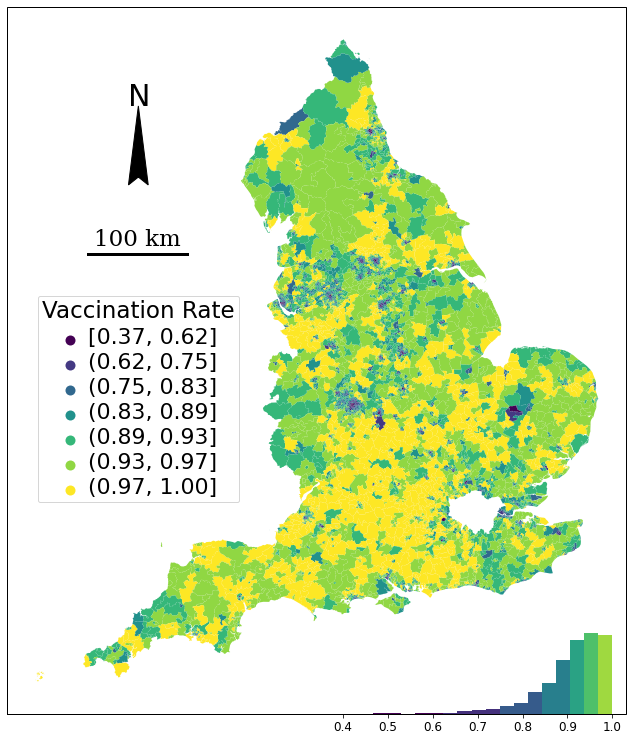

In [257]:
plt.close()
pop_rate_break('vaccination_percentage_1stdose')
plt.savefig('Results/vac_rate_1stdose', dpi=200,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


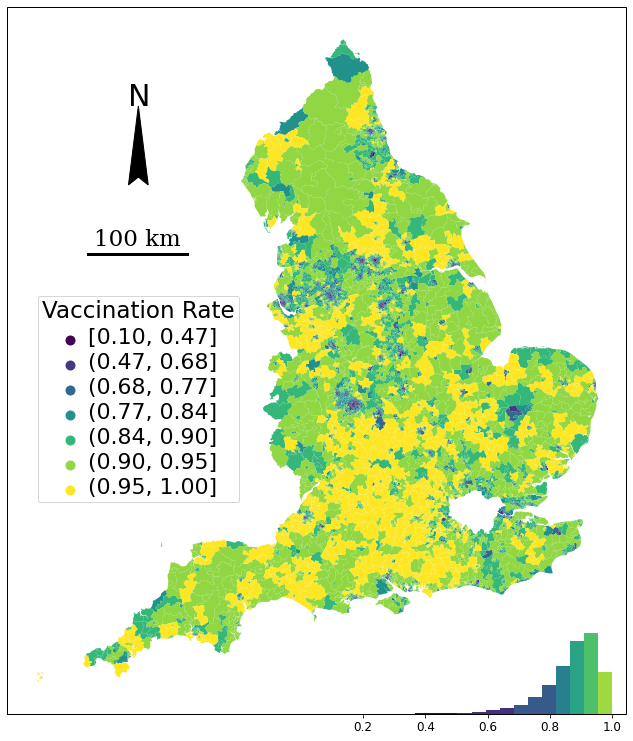

In [255]:
plt.close()
pop_rate_break('vaccination_percentage_2nddose')
plt.savefig('Results/vac_rate_2nddose', dpi=200,bbox_inches='tight')

/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


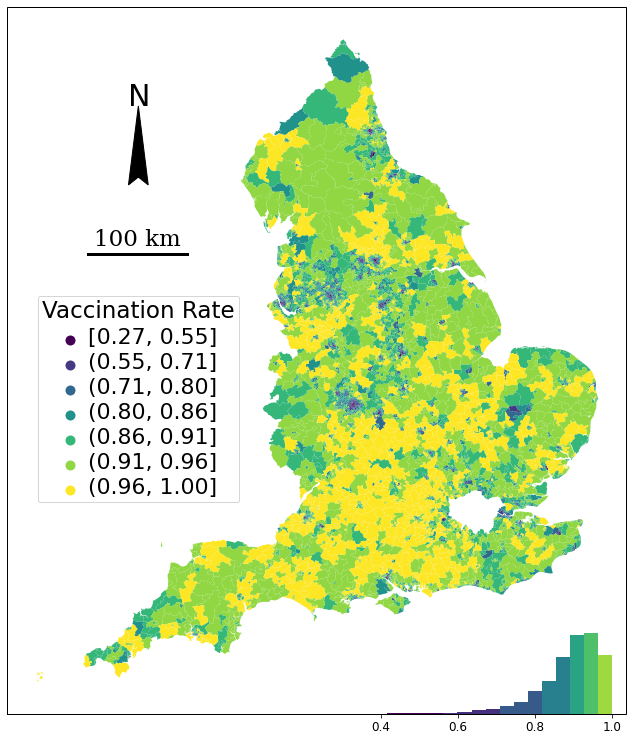

In [256]:
plt.close()
pop_rate_break('vaccination_percentage_total')
plt.savefig('Results/vac_rate_total', dpi=200,bbox_inches='tight')